# Web-scrapping (на примере youtube)
* selenium (использование браузера с помощью python)
* beautifulsoup (парсинг страницы)
* attrs
----

#### библиотеки

In [83]:
from selenium import webdriver
from selenium.webdriver.common.keys import Keys 
from bs4 import BeautifulSoup 
import pandas as pd
import time
import unicodedata
import numpy as np
import pickle
from tqdm import tqdm_notebook
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
from nltk.stem.snowball import SnowballStemmer
import warnings
warnings.filterwarnings('ignore')
import unicodedata
import requests

import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
from pymystem3 import Mystem
from string import punctuation
import time
from selenium.webdriver import Chrome
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
import string
from nltk.stem.snowball import SnowballStemmer
import seaborn as sns
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Sergey\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### функция, загружающая html страницу

<img src="hova_videos.png">

In [140]:
def get_lemmas(df_hova_videos):
    '''
    лемматизация названий видео
    '''
    ##############################################################
    def stem_string(string):
        punctuation = "!@#$%^&*()_+<>?:.,;-"  
        s2 = string.lower().strip()
        for c in s2:
            if c in punctuation:
                s2 = s2.replace(c, "")    
        words = s2.split(' ')
        return [stemmer.stem(word) for word in words if word !='']
    ###################################################################
    from nltk.corpus import stopwords
    russian_stopwords = stopwords.words("russian")
    stemmer = SnowballStemmer("russian") 
    lemmas= []
    for i in tqdm_notebook(range(len(df_hova_videos))):
        lemmas.extend(stem_string(df_hova_videos.iloc[i]['title']))
    lemmas_ser = pd.Series(lemmas)
    return lemmas_ser[lemmas_ser.apply(lambda x: x not in russian_stopwords)]    

def get_comments(url, n_iterations):
       
    driver = webdriver.Chrome()
    data=[]
    driver.get(url)
    for item in tqdm_notebook(range(n_iterations)):
        wait = WebDriverWait(driver,15)
        wait.until(EC.visibility_of_element_located((By.TAG_NAME, "body"))).send_keys(Keys.END)
        time.sleep(.1)
    for comment in tqdm_notebook(wait.until(EC.presence_of_all_elements_located((By.CSS_SELECTOR, "#content")))):
        data.append(comment.text)
    driver.close()
    
    table = str.maketrans('', '', string.punctuation)
    stemmer = SnowballStemmer("russian") 
    _stopwords = stopwords.words('russian')
    LL = []
    for row in data:
        _row = row.strip().lower()
        _row = ''.join([w.translate(table) for w in _row])
        for word in _row.split(' '):
            _w = stemmer.stem(word)
            if (_w not in _stopwords) & (_w!=''):
                LL.append(_w)
    
    return pd.Series(LL).value_counts().head(10).index.tolist()  


def get_all_tags(soup):
    return list(set([tag.name for tag in soup.find_all()]))
def get_yt_chanel_all_videos_info(user_name):
    D_MONTHS = {'янв.':1, 'февр.':2, 'мар.':3, 'апр.':4,\
            'мая':5,  'июн.':6, 'июл.':7, 'авг.':8,\
            'сент.':9,'окт.':10,'нояб.':11,'дек.':12}    
    YT_MAIN = "https://www.youtube.com"
    link_to_all_videos = f"https://www.youtube.com/c/{user_name}/videos"
    
    # открываем страницу в браузере
    driver = webdriver.Chrome()
    driver.get(link_to_all_videos)
    # с помощью webdriver полностью проматываю страницу, чтобы отображались все видео канала
    scroll_counter=0
    while scroll_counter!=50:
        # читаем страницу
        html_prev = driver.page_source         
        # скролим вниз
        html_next = driver.find_element_by_tag_name('body').send_keys(Keys.END)
        scroll_counter+=1
        time.sleep(.3)

    # загружаем промотанную страницу в BeautifulSoup
    soup = BeautifulSoup(driver.page_source, "html.parser")
    L = []

    # уже нашли, какие теги отвечают за ссылку на видео
    for i in soup.findAll('a',class_='yt-simple-endpoint style-scope ytd-grid-video-renderer'):
        # ссылка
        link = YT_MAIN+i['href'] 
        title = i['title']
        view_counter = np.int32(unicodedata.normalize("NFKD", i['aria-label'].split(' ')[-2]).replace(' ', ''))
        L.append((title, link, view_counter))

    # датафрейм с названием видео и ссылкой на него
    df_videos= pd.DataFrame(L, columns =['title', 'url', 'view_counter']).set_index('url')
    
    # проходим по выгруженным урлам
    for url in tqdm_notebook(df_videos.index):

        # код страницы
        content = requests.get(url).content

        # загружаем в BeautifulSoup
        soup = BeautifulSoup(content, "html.parser")

        # итерируемся по тегу body (в body лежит информация с лайками/дизлайками)
        for body in soup.find_all('body'):
            # итерируемся по тегу script
            for script in body.find_all('script'):
                # преобразуем в строку
                s = str(script)
                # ищем строку, где есть Нра
                if 'Нра' in s:
                    s_like = s
                for el in s.split(','):
                    if 'dateText' in el:
                        pub_date = el.split(':')[-1][1:-4]

        # разбиваем строку по разделителям, нормализуем(удаляем юникод-символы)
        # ищем подстроку с оценками
        # сохраняем
        for row in s_like.split(','):    
            if 'Видео понравилось' in row:
                like_row = row
                like_counter = np.int32(unicodedata.normalize("NFKD", like_row[:-16].split(' ')[-1])\
                                                   .replace(' ', '')\
                                                   .strip())
            elif 'Видео не понравилось' in row:
                dislike_row = row
                dislike_counter = np.int32(unicodedata.normalize("NFKD", dislike_row[:-16].split(' ')[-1])\
                                                      .replace(' ', '')\
                                                      .strip())
        df_videos.loc[url, 'like_counter'] = like_counter
        df_videos.loc[url, 'dislike_counter'] = dislike_counter
        df_videos.loc[url, 'date_publication'] = pub_date
    
    # конвертируем строковую дату в timestamp
    for i in df_videos.index:
        date_str = df_videos.loc[i, 'date_publication']
        try:
            daynumber, month, year, tail = date_str.split(' ')        
        except:
            daynumber, month, year = dt_row.split(' ')[3:-1]
        d, m, y = np.int32(daynumber), np.int32(D_MONTHS[month]), np.int32(year)
        timestamp = pd.Timestamp(year=y, month=m, day=d)
        df_videos.loc[i, 'date_publication'] = timestamp
    
    return df_videos    

In [13]:
# открываем страницу в браузере
driver = webdriver.Chrome()
# driver.get("https://www.youtube.com/c/ЮрийХованский69/videos")


#### выгружаем названия и адреса всех видео канала

In [20]:
YT_MAIN = 'https://www.youtube.com'
# с помощью webdriver полностью проматываю страницу, чтобы отображались все видео канала
scroll_counter=0
while scroll_counter!=50:
    # читаем страницу
    html_prev = driver.page_source         
    # скролим вниз
    html_next = driver.find_element_by_tag_name('body').send_keys(Keys.END)
    scroll_counter+=1
    time.sleep(.3)

# загружаем промотанную страницу в BeautifulSoup
soup = BeautifulSoup(driver.page_source, "html.parser")
L = []
    
# уже нашли, какие теги отвечают за ссылку на видео
for i in soup.findAll('a',class_='yt-simple-endpoint style-scope ytd-grid-video-renderer'):
    # ссылка
    link = YT_MAIN+i['href'] 
    title = i['title']
    view_counter = np.int32(unicodedata.normalize("NFKD", i['aria-label'].split(' ')[-2]).replace(' ', ''))
    L.append((title, link, view_counter))

# датафрейм с названием видео и ссылкой на него
df_videos= pd.DataFrame(L, columns =['title', 'url', 'view_counter']).set_index('url')

In [ ]:
# первые 5 видео
df_videos.head(5)

In [ ]:
# последние 5 видео
df_videos.tail(5)

#### выгружаем дату публикации, лайки, дизлайки

In [ ]:
# проходим по выгруженным урлам
for url in tqdm_notebook(df_videos.index):
    
    # код страницы
    content = requests.get(url).content
    
    # загружаем в BeautifulSoup
    soup = BeautifulSoup(content, "html.parser")
    
    # итерируемся по тегу body (в body лежит информация с лайками/дизлайками)
    for body in soup.find_all('body'):
        # итерируемся по тегу script
        for script in body.find_all('script'):
            # преобразуем в строку
            s = str(script)
            # ищем строку, где есть Нра
            if 'Нра' in s:
                s_like = s
            for el in s.split(','):
                if 'dateText' in el:
                    pub_date = el.split(':')[-1][1:-4]
                
    # разбиваем строку по разделителям, нормализуем(удаляем юникод-символы)
    # ищем подстроку с оценками
    # сохраняем
    for row in s_like.split(','):    
        if 'Видео понравилось' in row:
            like_row = row
            like_counter = np.int32(unicodedata.normalize("NFKD", like_row[:-16].split(' ')[-1])\
                                               .replace(' ', '')\
                                               .strip())
        elif 'Видео не понравилось' in row:
            dislike_row = row
            dislike_counter = np.int32(unicodedata.normalize("NFKD", dislike_row[:-16].split(' ')[-1])\
                                                  .replace(' ', '')\
                                                  .strip())
    df_videos.loc[url, 'like_counter'] = like_counter
    df_videos.loc[url, 'dislike_counter'] = dislike_counter
    df_videos.loc[url, 'date_publication'] = pub_date   
    

for i in df_videos.index:
    date_str = df_videos.loc[i, 'date_publication']
    try:
        daynumber, month, year, tail = date_str.split(' ')        
    except:
        daynumber, month, year = dt_row.split(' ')[3:-1]
    d, m, y = np.int32(daynumber), np.int32(d_months[month]), np.int32(year)
    timestamp = pd.Timestamp(year=y, month=m, day=d)
    df_videos.loc[i, 'date_publication'] = timestamp

In [44]:
# df_videos.to_pickle('df_videos.pickle')

In [15]:
# d_months = {'янв.':1, 'февр.':2, 'мар.':3, 'апр.':4,\
#             'мая':5,  'июн.':6, 'июл.':7, 'авг.':8,\
#             'сент.':9,'окт.':10,'нояб.':11,'дек.':12}
# for i in df_videos.index:
#     date_str = df_videos.loc[i, 'date_publication']
#     try:
#         daynumber, month, year, tail = date_str.split(' ')        
#     except:
#         daynumber, month, year = dt_row.split(' ')[3:-1]
#     d, m, y = np.int32(daynumber), np.int32(d_months[month]), np.int32(year)
#     timestamp = pd.Timestamp(year=y, month=m, day=d)
#     df_videos.loc[i, 'date_publication'] = timestamp

In [ ]:
df_videos = pd.read_pickle('df_videos.pickle')

In [40]:
df_videos.head()

,title,view_counter,like_counter,dislike_counter,date_publication
url,,,,,
https://www.youtube.com/watch?v=lCN-OGZPuXU,VERSUS BATTLE: ПЕРЕЗАГРУЗКА,515043,11125.0,11012.0,2021-06-07 00:00:00
https://www.youtube.com/watch?v=jxK2bbSGRB0,ВОЗДУШНЫЙ ЦИРК АЛЕКСАНДРА ЛУКАШЕНКО,392847,25569.0,2650.0,2021-06-03 00:00:00
https://www.youtube.com/watch?v=FmiuTIDxdGI,МОИ САМЫЕ ТУПЫЕ ПОКУПКИ (ПОТРАТИЛ 400к на ФУФЛО),270213,17344.0,1380.0,2021-05-31 00:00:00
https://www.youtube.com/watch?v=dKtoKzfooF0,УСТАЛ ОТ ЖИЗНИ БЛОГЕРА И УСТРОИЛСЯ НА РАБОТУ,194173,8284.0,6324.0,2021-05-27 00:00:00
https://www.youtube.com/watch?v=HvpytFS0m1w,ИНСТАСАМКА ОБЪЯВИЛА ВОЙНУ ЯНДЕКСУ,288338,10217.0,1433.0,2021-05-23 00:00:00


In [185]:
for url in tqdm_notebook(df_videos.index):
    df_videos.loc[url, 'text'] = ','.join(get_comments(url=url, n_iterations=100))

KeyboardInterrupt: 

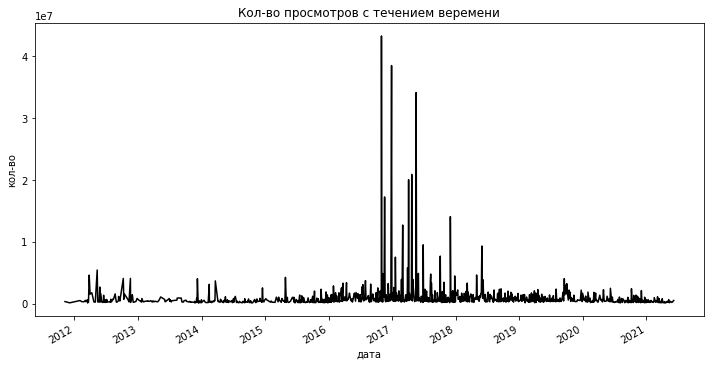

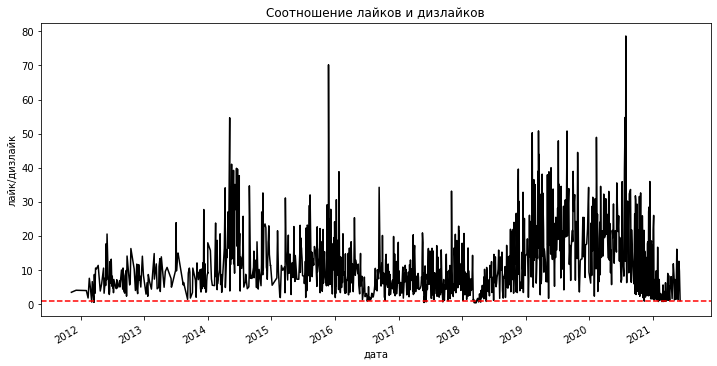

In [186]:
df_videos.set_index('date_publication')['view_counter'].plot(figsize = (12, 6), color='black')
plt.title('Кол-во просмотров с течением веремени')
plt.xlabel('дата')
plt.ylabel('кол-во');
plt.show()

(df_videos.set_index('date_publication')['like_counter'] / df_videos.set_index('date_publication')['dislike_counter'])\
    .plot(figsize = (12, 6), color='black')
plt.axhline(1, color='red', linestyle='--')
plt.title('Соотношение лайков и дизлайков')
plt.xlabel('дата')
plt.ylabel('лайк/дизлайк');
plt.show()

In [232]:
df_videos[['date_publication', 'title', 'text']].reset_index(drop = True).head(10)

,date_publication,title,text
0,2021-06-07 00:00:00,VERSUS BATTLE: ПЕРЕЗАГРУЗКА,"недел,теб,юр,свободухованск,эт,дня,виде,ден,хо..."
1,2021-06-03 00:00:00,ВОЗДУШНЫЙ ЦИРК АЛЕКСАНДРА ЛУКАШЕНКО,"эт,месяц,виде,недел,хов,ег,песн,посад,юр,ролик"
2,2021-05-31 00:00:00,МОИ САМЫЕ ТУПЫЕ ПОКУПКИ (ПОТРАТИЛ 400к на ФУФЛО),"месяц,эт,юр,пылесос,гта,теб,куп,робот,рп,виде"
3,2021-05-27 00:00:00,УСТАЛ ОТ ЖИЗНИ БЛОГЕРА И УСТРОИЛСЯ НА РАБОТУ,"месяц,эт,гта,рп,юр,хов,назад\n,когд,ролик,теб"
4,2021-05-23 00:00:00,ИНСТАСАМКА ОБЪЯВИЛА ВОЙНУ ЯНДЕКСУ,NaN
5,2021-05-19 00:00:00,МЕСЯЦ СПАЛ ПО 12 ЧАСОВ В ДЕНЬ. ЧТО ИЗМЕНИЛОСЬ?,NaN
6,2021-05-15 00:00:00,МОРТАЛ КОМБАТ 2021 - ЦАРЬ ВСЕХ РЕМЕЙКОВ,NaN
7,2021-05-12 00:00:00,"НАВАЛЬНЫЙ, ЛУКАШЕНКО И ВЫСЫЛКА ДИПЛОМАТОВ",NaN
8,2021-05-09 00:00:00,КАК ИВАНГАЙ СОШЁЛ С УМА ПОСЛЕ ИНТЕРВЬЮ ДУДЯ,NaN
9,2021-05-06 00:00:00,"ПРОБУЮ ЗОЖ: ПРАВИЛЬНО ПИТАЮСЬ, ХУДЕЮ К ЛЕТУ, К...",NaN


#### самый популярный ролик

In [233]:
df_videos.sort_values('view_counter', ascending = False).head(1)

,title,view_counter,like_counter,dislike_counter,date_publication,text,ym
url,,,,,,,
https://www.youtube.com/watch?v=8TX9zpTqZrc,МС ХОВАНСКИЙ - Батя в Здании,43292077,1206492.0,108613.0,2016-10-31 00:00:00,NaN,201610


#### ролик с максимальным числом лайков

In [234]:
df_videos.sort_values('like_counter', ascending = False).head(1)

,title,view_counter,like_counter,dislike_counter,date_publication,text,ym
url,,,,,,,
https://www.youtube.com/watch?v=8TX9zpTqZrc,МС ХОВАНСКИЙ - Батя в Здании,43292077,1206492.0,108613.0,2016-10-31 00:00:00,NaN,201610


#### ролик с максимальным числом дизлайков

In [235]:
df_videos.sort_values('dislike_counter', ascending = False).head(1)

,title,view_counter,like_counter,dislike_counter,date_publication,text,ym
url,,,,,,,
https://www.youtube.com/watch?v=b2WoZBi5ZtI,МС ХОВАНСКИЙ - Дисс на Летсплейщиков,4247117,151829.0,330568.0,2017-05-27 00:00:00,NaN,201705


#### ролик с минимальным рейтингом у аудитории

In [236]:
ttl = df_videos.loc[(df_videos['dislike_counter'] / df_videos['like_counter']).sort_values(ascending = True).index[-1], 'title']
idx = np.argwhere(df_videos['title'].values == ttl).flatten()[0]
df_videos.iloc[[idx-1,idx,idx+2]]

,title,view_counter,like_counter,dislike_counter,date_publication,text,ym
url,,,,,,,
https://www.youtube.com/watch?v=Q95xmSBv_3Q,ШАВЕРМА ИЗ ГИПЕРМАРКЕТА,870053,26150.0,41629.0,2018-03-23 00:00:00,NaN,201803
https://www.youtube.com/watch?v=qVz0WYKzmCw,ВЫЖИВАЕМ В СЕЗОН ГРИППА,280072,9789.0,32164.0,2018-03-21 00:00:00,NaN,201803
https://www.youtube.com/watch?v=071BAkdAzkc,"МС ХОВАНСКИЙ - Секс, Бухло, Русский Рэп",1882290,61689.0,173695.0,2018-03-13 00:00:00,NaN,201803


#### ролик с минимальным рейтингом у аудитории

In [237]:
ttl = df_videos.loc[(df_videos['dislike_counter'] / df_videos['like_counter']).sort_values(ascending = True).index[0], 'title']
idx = np.argwhere(df_videos['title'].values == ttl).flatten()[0]
df_videos.iloc[[idx-1,idx,idx+2]]

,title,view_counter,like_counter,dislike_counter,date_publication,text,ym
url,,,,,,,
https://www.youtube.com/watch?v=buwBUVhVwng,САМЫЙ ДЕШЕВЫЙ ВИСКАРЬ vs САМЫЙ ДОРОГОЙ ВИСКИ,354041,22694.0,1089.0,2020-08-01 00:00:00,NaN,202008
https://www.youtube.com/watch?v=PoJFMObtPfU,СМОТРИМ ГЕЙСКИЕ МОМЕНТЫ ИЗ НАШИХ РОЛИКОВ,1069221,113502.0,1443.0,2020-07-30 00:00:00,NaN,202007
https://www.youtube.com/watch?v=59U3lkCSHPs,НЕЗАШКВАРНЫЕ ИСТОРИИ (Хованский VS Власов),286224,28970.0,529.0,2020-07-26 00:00:00,NaN,202007
